In [1]:
from pathlib import Path
from datetime import datetime
import sys
import yaml
from time import time
import os
import copy
from geopy.geocoders import GoogleV3, Nominatim
import matplotlib.dates as mdates
from numpy import median

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import lines

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim, Config
from SCanalyzer.busSim.manager import managerFactory
from SCanalyzer.gtfs_edit import edit_double
from SCanalyzer.util import findEPSG
from SCanalyzer.busSim.manager import LocalManager
from pyproj import Transformer
from shapely.geometry import Point

import matplotlib.pyplot as plt
from matplotlib import lines

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

from shapely import geometry

%matplotlib inline

manger init
mangager register
mangager register


In [2]:
background_path = os.path.join('..', 'data', 'plot', 'background')
city = gpd.read_file(os.path.join(background_path, "madison-meter-shp")).to_crs(4326)
# lakes = gpd.read_file(os.path.join(background_path, "Rivers.zip")).to_crs(4326)
# street = gpd.read_file(os.path.join(background_path, "Roads.zip")).to_crs(4326)
max_lon = city.bounds.maxx.max()
min_lon = city.bounds.minx.min()
max_lat = city.bounds.maxy.max()
min_lat = city.bounds.miny.min()

In [3]:
import math

def get_sigmoid(x):
    return 1/(1+math.e**(-x)) - 0.5

def get_score(area, banks=0, clinics=0, dentists=0, hospitals=0, supermarkets=0):
    # y = sqrt(x), sigmoid, saturated functions
    score = get_sigmoid(banks) + get_sigmoid(clinics) + get_sigmoid(hospitals) + get_sigmoid(dentists) + get_sigmoid(supermarkets)
    return score

In [4]:
api_key = 'ZsHZFGtKEZeOOXhTne98eErmfd6BfNTm9GqO2S6inSnWzDwtgC2sEauXcB-8zUna_lXZEal4jsW_St6O0OQOcuNvifrr6uqNYmjFXW-FyVKvaMyczbihWELI80tjYHYx'
gtfo = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
census_gdf = gtfo.load_census()
services_gdf = gtfo.load_yelp(api_key=api_key)

stops_meter exists


In [5]:
temp_df = services_gdf.apply(copy.deepcopy)

epsg = 3174
transformer = Transformer.from_crs(4326, epsg)
stop_x, stop_y = transformer.transform(
            temp_df['latitude'], temp_df['longitude'])
temp_df['stop_x'], temp_df['stop_y'] = stop_x, stop_y

In [6]:
# the number of each building in each census block
city = city.to_crs(epsg)

new_census = census_gdf.to_crs(epsg).intersection(city.unary_union)
census_union = gpd.GeoDataFrame(geometry=new_census, crs=epsg)

new_census = census_gdf.to_crs(epsg).copy(True)
new_census['banks'] = 0
new_census['clinics'] = 0
new_census['dentists'] = 0
new_census['hospitals'] = 0
new_census['supermarket'] = 0
for idx, row in new_census.iterrows():
    for _, service in temp_df.iterrows():
        if row.geometry.contains(Point(service.stop_x, service.stop_y)):
            new_census.loc[idx, service['service']] += 1

In [7]:
new_census['score'] = 0
for idx, row in new_census.iterrows():
    new_census.loc[idx, 'score'] = get_score(0, row['banks'], row['clinics'], row['dentists'], row['hospitals'], row['supermarket'])

In [8]:
new_census = new_census.to_crs(4326)

In [9]:
polys = [(min_lon, min_lat), (min_lon, max_lat), (max_lon, min_lat), (max_lon, max_lat)]
s = gpd.GeoSeries(geometry.Polygon(polys).convex_hull)
res = new_census.apply(lambda row: s.contains(row['geometry'].centroid), axis=1)
new_census = new_census[res[0]]
# s.contains(new_census.centroid)

In [10]:
new_census_sorted = new_census[new_census['score'] != 0].sort_values('score')
points_low = new_census_sorted.head(10)
points_high = new_census_sorted.tail(10)

In [19]:
points_high

,STATE,COUNTY,TRACT,BLKGRP,geometry,NAME,B02001_001E,B02001_002E,B02001_003E,B02001_004E,...,% American Indian and Alaska Native alone,% Asian alone alone,% Native Hawaiian and Other Pacific Islander alone,cars per capita,banks,clinics,dentists,hospitals,supermarket,score
9,55,25,11000,1,"POLYGON ((-89.51666 43.09683, -89.51793 43.095...","Block Group 1, Census Tract 110, Dane County, ...",1787,1675,71,0,...,0.000000,0.008394,0.000000,0.491326,1,4,5,0,1,1.437438
122,55,25,1300,2,"POLYGON ((-89.40146 43.05779, -89.40403 43.056...","Block Group 2, Census Tract 13, Dane County, W...",718,569,0,15,...,0.020891,0.144847,0.000000,0.543175,1,4,0,3,2,1.546444
114,55,25,300,1,"POLYGON ((-89.46494 43.07485, -89.46365 43.071...","Block Group 1, Census Tract 3, Dane County, Wi...",2569,1295,54,9,...,0.003503,0.443363,0.000000,0.601401,2,4,4,0,1,1.575883
238,55,25,204,1,"POLYGON ((-89.51030 43.07265, -89.51040 43.070...","Block Group 1, Census Tract 2.04, Dane County,...",1294,822,385,0,...,0.000000,0.053323,0.000000,0.402628,1,5,8,2,0,1.604827
252,55,25,1403,3,"POLYGON ((-89.42854 43.01104, -89.42772 43.006...","Block Group 3, Census Tract 14.03, Dane County...",3375,2842,252,0,...,0.000000,0.050667,0.000000,0.530963,4,4,2,2,0,1.725622
269,55,25,11402,2,"POLYGON ((-89.31221 43.16461, -89.30979 43.160...","Block Group 2, Census Tract 114.02, Dane Count...",1562,1206,12,0,...,0.000000,0.140845,0.000000,0.549296,2,6,6,3,0,1.828426
103,55,25,10501,2,"POLYGON ((-89.33611 43.04707, -89.33442 43.046...","Block Group 2, Census Tract 105.01, Dane Count...",1789,1417,199,0,...,0.000000,0.017887,0.000000,0.396870,4,4,8,2,0,1.844489
13,55,25,10100,1,"POLYGON ((-89.44602 43.08592, -89.44955 43.084...","Block Group 1, Census Tract 101, Dane County, ...",1039,871,11,19,...,0.018287,0.081809,0.001925,0.413859,1,7,2,2,2,1.872539
199,55,25,10901,1,"POLYGON ((-89.57627 43.08034, -89.57614 43.074...","Block Group 1, Census Tract 109.01, Dane Count...",7744,5605,162,2,...,0.000258,0.201705,0.000000,0.461777,9,16,9,3,1,2.183386
206,55,25,408,1,"POLYGON ((-89.50309 43.05332, -89.50309 43.053...","Block Group 1, Census Tract 4.08, Dane County,...",1439,1005,84,4,...,0.002780,0.107019,0.000000,0.605281,5,18,10,4,1,2.206334


In [11]:
points = {"low": [(p.y, p.x) for p in points_low.centroid],
    "high": [(p.y, p.x) for p in points_high.centroid]}

/var/folders/v_/6c5ts29s0gd2d_5_syjrk88c0000gn/T/ipykernel_60783/724660934.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points = {"low": [(p.y, p.x) for p in points_low.centroid],
/var/folders/v_/6c5ts29s0gd2d_5_syjrk88c0000gn/T/ipykernel_60783/724660934.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  "high": [(p.y, p.x) for p in points_high.centroid]}


In [12]:
def flatten(s, crs):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union]), 'crs': crs})

def gen_busSim(data_path=None, out_path=None, day=None, start_time=None, elapse_time=None, avg_walking_speed=None, max_walking_min=None):
    manager = LocalManager(data_path, out_path, None)
    busSim = BusSim(manager, day, start_time, elapse_time, avg_walking_speed, max_walking_min)
    return busSim

def get_area(start_points=[], start_locations=[], busSim=None, crs=None, city=None):
    if len(start_points)==0:
        geolocator = Nominatim(user_agent="user_test")
        for loc in start_locations:
            location = geolocator.geocode(loc)
            print(location)
            start_point = (location.latitude, location.longitude)
            start_points.append(start_point)
    
    area_dict = {}
    # print(f'{start_points=}')
    for index, start in enumerate(start_points):
        # print(f'{start=}')
        gdf = busSim.get_gdf(start_point=start)
        busSim.clear_graph()
        if gdf is None:
            area_dict[f'{start_points[index]}'] = 0
            continue
        gdf = gdf.to_crs(epsg=crs)
        bubble = flatten(gdf.geometry, crs)
        new_census2 = new_census.to_crs(crs).intersection(bubble.unary_union)
        new_census2 = gpd.GeoDataFrame(geometry=new_census2, crs=crs)
        new_census2['score'] = new_census['score']
        # print(f'{new_census2.head()=}')
        area_dict[f'{start_points[index]}'] = new_census2[~new_census2['geometry'].is_empty]['score'].sum()
    # print(f'{area_dict=}')
    return area_dict

def draw_area_times(times, areas, data_path, results):
    fig, ax = plt.subplots(figsize=(12,8)) 
    times = list(map(lambda x: datetime.strptime(x.capitalize(), "%A %H:%M:%S  %d"), times))
    formatter = mdates.DateFormatter("%a %H:%M")
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gcf().autofmt_xdate()
    
    for key in areas.keys():
        # print(f'loc {key}')
        # print(f'{areas[key]=}')
        # print(f'min value: {min(areas[key])}')
        results['min score'].append(min(areas[key]))
        results['max score'].append(max(areas[key]))
        results['median score'].append(median(areas[key]))
        # print(f'max value: {max(areas[key])}')
        geoloctor = Nominatim(user_agent="reverse_user")
        info = geoloctor.reverse(key[1:-1]).raw
        if info != None:
            info = info['address']
            addr = ''
            for index, addrkey in enumerate(info):
                if index > 1:
                    break
                addr += " " + info[addrkey]
        else:
            addr = key
        ax.plot(times, areas[key], label = addr)
        results['label'].append(addr)
    
    ax.set_ylim(bottom=0)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Time', fontsize=18)
    plt.ylabel("score", fontsize=18)
    plt.title('Score vs Time', fontsize=20)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.savefig('mearsurement_plot.png', bbox_inches='tight')

def run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results):
    prog_start = time()
    areas = {}
    for start_time in start_times:
        # print('creat busSim')
        day, start = start_time.split(' ')
        busSim = gen_busSim(DATA_PATH,OUT_PATH, day, start, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)
        # print('cal area')
        for key, area in get_area(start_points=START_POINTS, start_locations=START_LOCATIONS, busSim=busSim, crs=crs).items():
            if key not in areas:
                areas[key] = []
                areas[key].append(float(area))
            else:
                areas[key].append(float(area))
    # print(f'{areas=}')
    pre_day = ''
    day_index = 0
    for index in range(len(start_times)):
        day, start = start_times[index].split(' ')
        if pre_day != day:
            day_index+=1
            pre_day = day
        start_times[index] = f"{start_times[index]}  {day_index}"
        
    print(start_times)
    draw_area_times(start_times, areas, DATA_PATH, results)
    duration = time() - prog_start
    # results['time'].append(duration)
    print(f'time taken {duration}')
    return duration

len(start_points_dict["high"])=10
stops_meter exists
['monday 00:00:00  1', 'monday 03:00:00  1', 'monday 06:00:00  1', 'monday 09:00:00  1', 'monday 12:00:00  1', 'monday 15:00:00  1', 'monday 18:00:00  1', 'monday 21:00:00  1', 'tuesday 00:00:00  2', 'tuesday 03:00:00  2', 'tuesday 06:00:00  2', 'tuesday 09:00:00  2', 'tuesday 12:00:00  2', 'tuesday 15:00:00  2', 'tuesday 18:00:00  2', 'tuesday 21:00:00  2', 'wednesday 00:00:00  3', 'wednesday 03:00:00  3', 'wednesday 06:00:00  3', 'wednesday 09:00:00  3', 'wednesday 12:00:00  3', 'wednesday 15:00:00  3', 'wednesday 18:00:00  3', 'wednesday 21:00:00  3', 'thursday 00:00:00  4', 'thursday 03:00:00  4', 'thursday 06:00:00  4', 'thursday 09:00:00  4', 'thursday 12:00:00  4', 'thursday 15:00:00  4', 'thursday 18:00:00  4', 'thursday 21:00:00  4', 'friday 00:00:00  5', 'friday 03:00:00  5', 'friday 06:00:00  5', 'friday 09:00:00  5', 'friday 12:00:00  5', 'friday 15:00:00  5', 'friday 18:00:00  5', 'friday 21:00:00  5', 'saturday 00:00:00

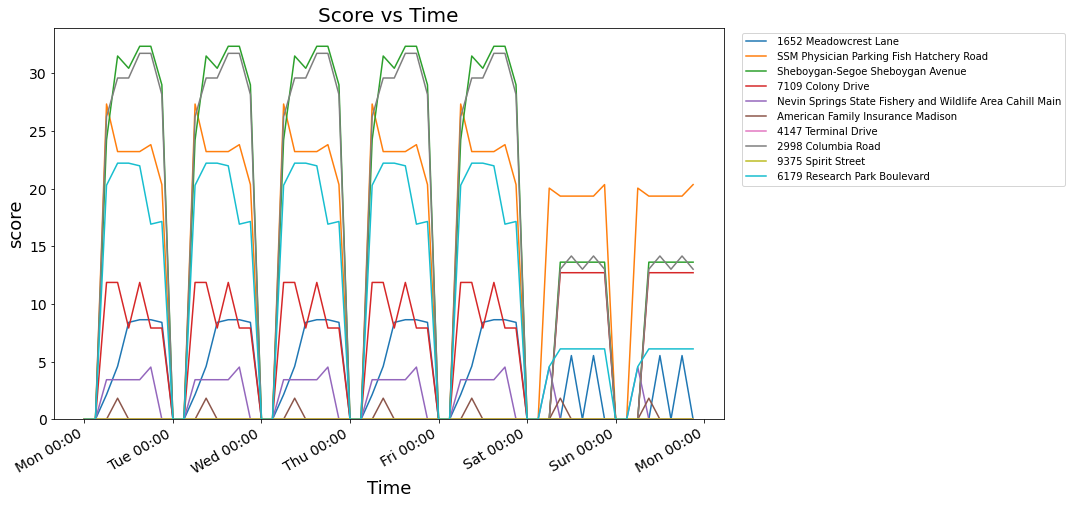

In [13]:
start_points_dict = points
results = {
    "label":[],
    "max score": [],
    "min score": [],
    "median score": []
}

print(f'{len(start_points_dict["high"])=}')
START_POINTS = start_points_dict['high']
ELAPSE_TIME = "00:30:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 12

DATA_PATH = "../data/mmt_gtfs.zip"
OUT_PATH = "/tmp/output" 
sc = SCanalyzer(DATA_PATH)
crs = 3174
START_LOCATIONS = []

runs = []
start_times = []
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
# days = ["monday"]
for day in days:
    for start_time in range(0,24,3):
        start_times.append('{} {:02}:{:02}:{:02}'.format(day, start_time, 0, 0))    
runs.append(run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results))

In [14]:
print(pd.DataFrame(results).to_markdown())

|    | label                                                     |   max score |   min score |   median score |
|---:|:----------------------------------------------------------|------------:|------------:|---------------:|
|  0 | 1652 Meadowcrest Lane                                     |     8.63154 |           0 |        4.59358 |
|  1 | SSM Physician Parking Fish Hatchery Road                  |    27.3281  |           0 |       20.3445  |
|  2 | Sheboygan-Segoe Sheboygan Avenue                          |    32.3336  |           0 |       24.2205  |
|  3 | 7109 Colony Drive                                         |    12.7064  |           0 |        7.91297 |
|  4 | Nevin Springs State Fishery and Wildlife Area Cahill Main |     4.52522 |           0 |        0       |
|  5 | American Family Insurance Madison                         |     1.82843 |           0 |        0       |
|  6 | 4147 Terminal Drive                                       |     0       |           0 |        0 

len(start_points_dict["low"])=10
stops_meter exists
['monday 00:00:00  1', 'monday 03:00:00  1', 'monday 06:00:00  1', 'monday 09:00:00  1', 'monday 12:00:00  1', 'monday 15:00:00  1', 'monday 18:00:00  1', 'monday 21:00:00  1', 'tuesday 00:00:00  2', 'tuesday 03:00:00  2', 'tuesday 06:00:00  2', 'tuesday 09:00:00  2', 'tuesday 12:00:00  2', 'tuesday 15:00:00  2', 'tuesday 18:00:00  2', 'tuesday 21:00:00  2', 'wednesday 00:00:00  3', 'wednesday 03:00:00  3', 'wednesday 06:00:00  3', 'wednesday 09:00:00  3', 'wednesday 12:00:00  3', 'wednesday 15:00:00  3', 'wednesday 18:00:00  3', 'wednesday 21:00:00  3', 'thursday 00:00:00  4', 'thursday 03:00:00  4', 'thursday 06:00:00  4', 'thursday 09:00:00  4', 'thursday 12:00:00  4', 'thursday 15:00:00  4', 'thursday 18:00:00  4', 'thursday 21:00:00  4', 'friday 00:00:00  5', 'friday 03:00:00  5', 'friday 06:00:00  5', 'friday 09:00:00  5', 'friday 12:00:00  5', 'friday 15:00:00  5', 'friday 18:00:00  5', 'friday 21:00:00  5', 'saturday 00:00:00 

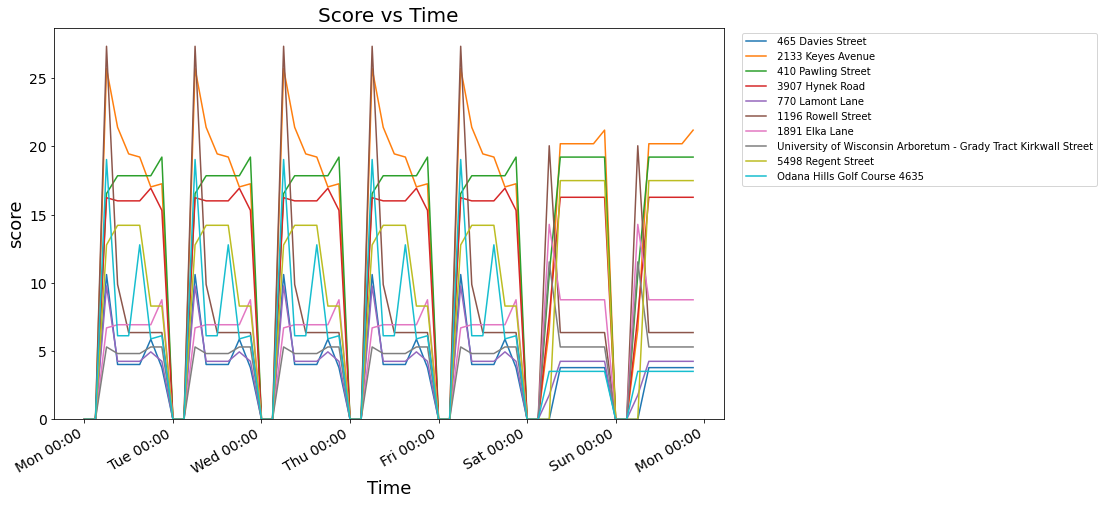

In [15]:
start_points_dict = points
results = {
    "label":[],
    "max score": [],
    "min score": [],
    "median score": []
}

print(f'{len(start_points_dict["low"])=}')
START_POINTS = start_points_dict['low']
ELAPSE_TIME = "00:30:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 12

DATA_PATH = "../data/mmt_gtfs.zip"
OUT_PATH = "/tmp/output" 
sc = SCanalyzer(DATA_PATH)
crs = 3174
START_LOCATIONS = []

runs = []
start_times = []
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
# days = ["monday"]
for day in days:
    for start_time in range(0,24,3):
        start_times.append('{} {:02}:{:02}:{:02}'.format(day, start_time, 0, 0))    
runs.append(run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results))

In [16]:
print(pd.DataFrame(results).to_markdown())

|    | label                                                           |   max score |   min score |   median score |
|---:|:----------------------------------------------------------------|------------:|------------:|---------------:|
|  0 | 465 Davies Street                                               |    10.6045  |           0 |        3.78525 |
|  1 | 2133 Keyes Avenue                                               |    25.6982  |           0 |       19.2128  |
|  2 | 410 Pawling Street                                              |    19.2096  |           0 |       17.8433  |
|  3 | 3907 Hynek Road                                                 |    16.9268  |           0 |       16.0026  |
|  4 | 770 Lamont Lane                                                 |     9.77114 |           0 |        4.24737 |
|  5 | 1196 Rowell Street                                              |    27.3281  |           0 |        6.3546  |
|  6 | 1891 Elka Lane                                   